In [9]:
import pandas as pd
df = pd.read_csv(r'C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Volga.csv')
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,node_158,node_159,"Udmurts,Besermyan","Udmurts,Besermyan",44.22830,5,11.81180
1,node_158,node_160,"Udmurts,Besermyan","Udmurts,Besermyan",32.09880,4,11.42640
2,node_158,node_161,"Udmurts,Besermyan","Udmurts,Besermyan",51.91020,6,10.48110
3,node_158,node_162,"Udmurts,Besermyan","Udmurts,Besermyan",35.44570,3,13.15160
4,node_158,node_163,"Udmurts,Besermyan","Udmurts,Besermyan",24.03060,2,16.08090
...,...,...,...,...,...,...,...
169374,node_16079,node_16098,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",Chuvash,10.51550,1,10.51550
169375,node_16079,node_16100,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",27.97480,2,21.79260
169376,node_16082,node_16086,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",28.95360,2,18.24450
169377,node_16086,node_16089,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",8.47385,1,8.47385


In [5]:
[[-100, -100, -100]] * 2

[[-100, -100, -100], [-100, -100, -100]]

In [11]:
df[['node_id1', 'node_id2']].to_csv('volga.edges', index=None, header=None)

In [14]:
from numba import njit

@njit(cache=True)
def tmp(np_array):
    new_arr = np_array[np_array != -1]
    return np.mean(new_arr)

tmp(np.array([1, 2, 3, 4, -1, -1, -1, 5, 6, 7, 8, -1]))

4.5

In [11]:
G = nx.path_graph(4)
nx.add_path(G, [10, 11, 12])
# [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
for c in nx.connected_components(G):
    print(list(c))

[0, 1, 2, 3]
[10, 11, 12]


In [5]:
import os
print(os.cpu_count())

112


# Libs

In [1]:
import pandas as pd
import networkx as nx
import torch
import numpy as np
import random
import sys
import os.path
from torch_geometric.utils import to_networkx
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir)))
from ancinf.utils.genlink import DataProcessor, NullSimulator, Trainer, BaselineMethods, TAGConv_3l_128h_w_k3, TAGConv_3l_512h_w_k3

# Get graph features

In [2]:
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/NC/raw/NC_graph_rel.csv')

<Figure size 640x480 with 0 Axes>

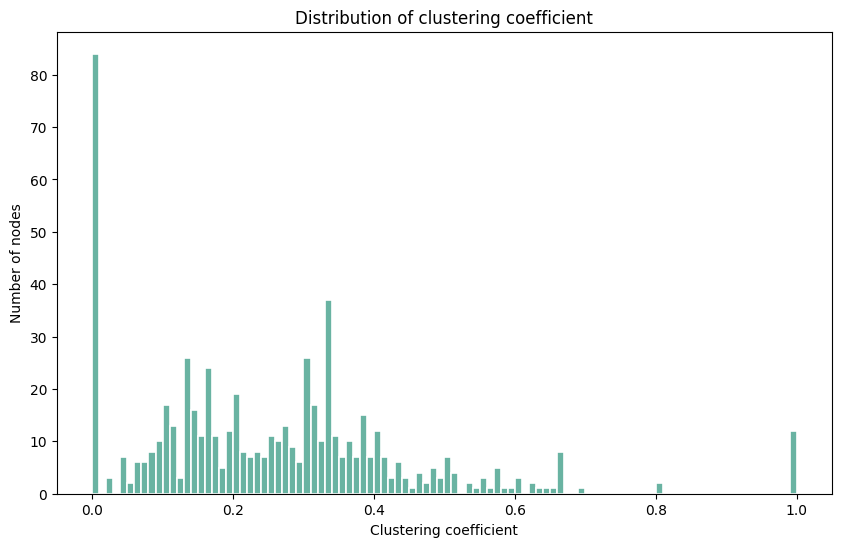

<Figure size 640x480 with 0 Axes>

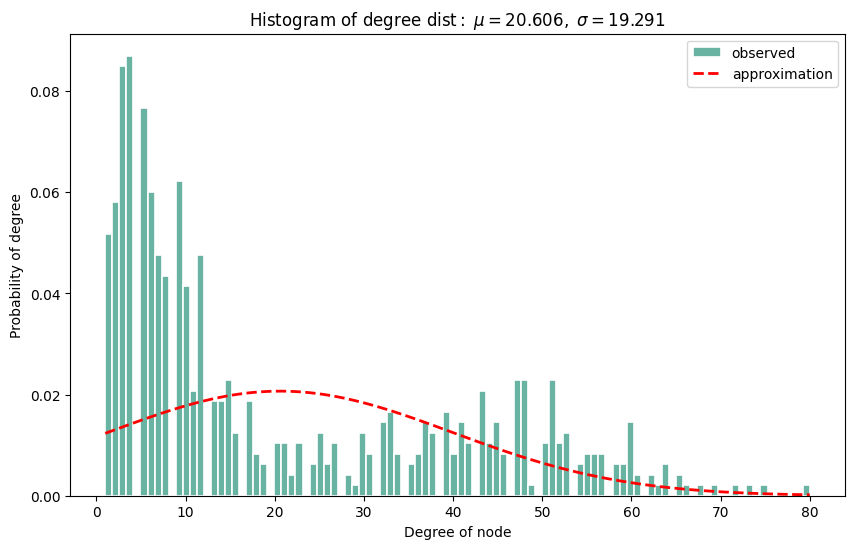

In [3]:
features = dp.get_graph_features(fig_path='/home/ashmelev/ancestry-inference/data/real_data/NC/imgs/', fig_size=(10, 6))

In [4]:
features

{'Number of nodes': 614,
 'Number of edges': 6297,
 'Density': 0.03346068621772561,
 'Self-loop edges': [],
 'Is connected': False,
 'Number of cc': 2,
 'Number of isolated nodes': 0,
 'Is planar': False,
 'Number of nodes in largest cc': 611,
 'Diameter': 14,
 'Radius': 7,
 'Transitivity': 0.34439711526295813,
 'Number of multi edges': 0,
 'Max degree': 80,
 'Mean degree': 20.605564648117838,
 'Min degree': 1,
 'Global efficiency': 0.34821064620924286,
 'Local efficiency': 0.399517466507326,
 'Degree assortativity coefficient': 0.46462230916520647,
 'Class assortativity coefficient': 0.6209474309427518,
 'Average clustering': 0.2544446080478868,
 'Center': ['342'],
 'Periphery': ['477', '481', '489', '520', '586'],
 'Is Eulerian': False,
 'Is semi-Eulerian': False,
 'Is regular': False,
 'Average shortest path length': 3.460980386895978,
 'Is tree': False,
 'Is forest': False,
 'Max degree centrality': 0.13114754098360656,
 'Mean degree centrality': 0.03377961417724236,
 'Min degree c

# Graph based features on simulations

In [2]:
tmp_cross_class_prob = 0
probs = np.array([[0.5, tmp_cross_class_prob], [tmp_cross_class_prob, 0.5]])
weights = np.array([[1.94265021,  1.94265021], [1.94265021, 1.94265021]])

ns = NullSimulator(2, probs, weights) # use first two classes of NC dataset as background

means, counts, pop_index = ns.generate_matrices([10]*2)

ns.simulate_graph(means, counts, pop_index, "/home/ashmelev/ancestry-inference/data/generated_nc/nc_null_simulations_10.csv")

dp = DataProcessor("/home/ashmelev/ancestry-inference/data/generated_nc/nc_null_simulations_10.csv")

dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_10')

trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, 10, "~/runs/nc_null", 2, 20, feature_type='one_hot', train_iterations_per_sample=100, evaluation_steps=10)

trainer.run()

n_pops=2
(2, 2, 10, 10)
Training for data: nc_null_sim_10


{'f1_macro': 1.0,
 'f1_weighted': 1.0,
 'accuracy': 1.0,
 'class_scores': {'class_0': 1.0, 'class_1': 1.0},
 'skipped_nodes': 0}

In [15]:
dp.array_of_graphs_for_training

[Data(x=[14, 6], edge_index=[2, 54], y=[14], weight=[54], num_classes=2)]

In [14]:
dp.array_of_graphs_for_training[0].x

tensor([[ 5.0000,  0.0000,  9.6039,  0.0000,  1.5480,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  9.3634,  0.0000,  0.7491],
        [ 0.0000,  4.0000,  0.0000, 10.4712,  0.0000,  1.1660],
        [ 4.0000,  0.0000,  9.0114,  0.0000,  0.5741,  0.0000],
        [ 2.0000,  0.0000, 10.4184,  0.0000,  0.3687,  0.0000],
        [ 5.0000,  0.0000, 11.7701,  0.0000,  3.2116,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  9.4296,  0.0000,  0.4809],
        [ 4.0000,  0.0000, 10.1301,  0.0000,  0.9686,  0.0000],
        [ 5.0000,  0.0000,  9.0133,  0.0000,  1.1490,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  8.6057,  0.0000,  0.7972],
        [ 0.0000,  3.0000,  0.0000,  8.7727,  0.0000,  0.8351],
        [ 3.0000,  0.0000, 11.5743,  0.0000,  4.3058,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  9.3757,  0.0000,  1.8050],
        [ 0.0000,  3.0000,  0.0000,  8.5375,  0.0000,  0.5325]],
       dtype=torch.float64)

In [21]:
dp.array_of_graphs_for_validation[1].x

tensor([[ 5.0000,  0.0000,  9.6039,  0.0000,  1.5480,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  9.3634,  0.0000,  0.7491],
        [ 0.0000,  4.0000,  0.0000, 10.4712,  0.0000,  1.1660],
        [ 4.0000,  0.0000,  9.0114,  0.0000,  0.5741,  0.0000],
        [ 2.0000,  0.0000, 10.4184,  0.0000,  0.3687,  0.0000],
        [ 5.0000,  0.0000, 11.7701,  0.0000,  3.2116,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  9.4296,  0.0000,  0.4809],
        [ 4.0000,  0.0000, 10.1301,  0.0000,  0.9686,  0.0000],
        [ 5.0000,  0.0000,  9.0133,  0.0000,  1.1490,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  8.6057,  0.0000,  0.7972],
        [ 0.0000,  3.0000,  0.0000,  8.7727,  0.0000,  0.8351],
        [ 3.0000,  0.0000, 11.5743,  0.0000,  4.3058,  0.0000],
        [ 0.0000,  4.0000,  0.0000,  9.3757,  0.0000,  1.8050],
        [ 0.0000,  3.0000,  0.0000,  8.5375,  0.0000,  0.5325],
        [ 0.0000,  3.0000,  0.0000,  9.0075,  0.0000,  0.8149]],
       dtype=torch.float64)

In [22]:
torch.all(dp.array_of_graphs_for_validation[1].x[:-1] == dp.array_of_graphs_for_training[0].x)

tensor(True)

In [12]:
dp.array_of_graphs_for_testing[0].y

tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1])

In [13]:
dp.array_of_graphs_for_training[0].y

tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

# Plot real probability matrix

In [8]:
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')
dp.compute_simulation_params()

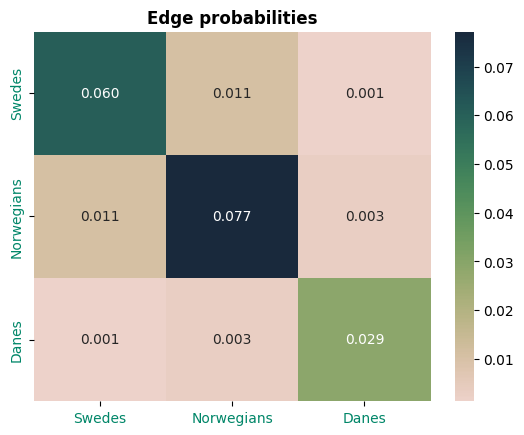

In [9]:
dp.plot_simulated_probs('/home/ashmelev/ancestry-inference/data/real_data/SC/imgs/probs.pdf')

# Test community detection

In [2]:
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')

In [3]:
dp.nx_graph.nodes[300] # check that those classes are correct

{'class': 1}

In [4]:
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)
# dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'tmp')

In [5]:
bm = BaselineMethods(dp)

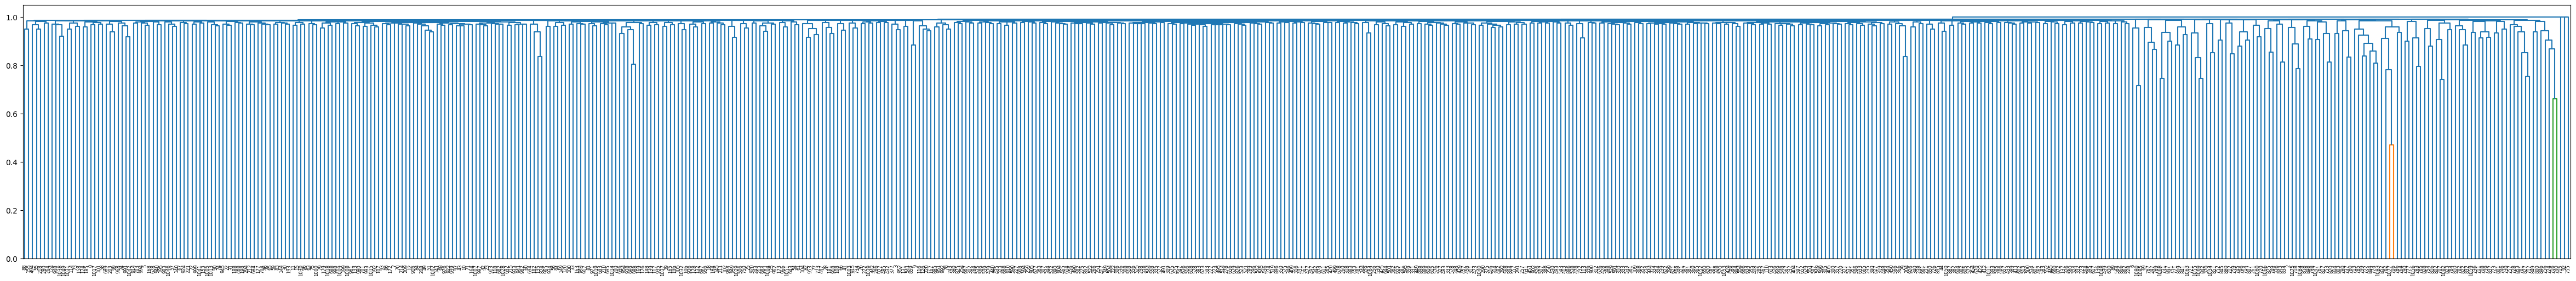

In [6]:
bm.plot_dendogram(dp.test_nodes[0], (60, 6), 6, '/home/ashmelev/ancestry-inference/data/real_data/SC/imgs/dendogram.pdf')

In [7]:
a = [[1, 2, 3], [4, 5, 6, 7, 8]]
[x for xx in a for x in xx]

[1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
bm.girvan_newman()

Girvan-Newman:   3%|▎         | 6/215 [31:11<18:06:13, 311.83s/it]


KeyboardInterrupt: 

In [6]:
bm.agglomerative_clustering()

Agglomerative clustering:  63%|██████▎   | 136/215 [01:58<01:00,  1.30it/s]

Isolated test node found, skipping!


Agglomerative clustering: 100%|██████████| 215/215 [03:08<00:00,  1.14it/s]

Homogenity score: 0.03093742191014009
f1 macro score on test dataset: 0.5140382006053648


0.5140382006053648

In [6]:
bm.spectral_clustering()

Spektral clustering:  64%|██████▍   | 138/215 [00:29<00:11,  6.90it/s]

Isolated test node found, skipping!


Spektral clustering: 100%|██████████| 215/215 [00:44<00:00,  4.79it/s]

Homogenity score: 0.7350975085748094
f1 macro score on test dataset: 0.9444176864271513


0.9444176864271513

In [15]:
nx_test_subgraph = dp.nx_graph.subgraph(list(dp.train_nodes) + [dp.test_nodes[0]])

In [16]:
dp.test_nodes[0]

905

In [11]:
numba_subgraph = nx.Graph(to_networkx(dp.array_of_graphs_for_testing[0]))

In [13]:
for c in nx.connected_components(numba_subgraph):
    print(list(c))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223

In [12]:
for c in nx.connected_components(nx_test_subgraph):
    print(list(c))

[0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 15, 18, 22, 23, 24, 25, 28, 29, 30, 31, 33, 39, 41, 42, 43, 44, 46, 49, 51, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 88, 89, 90, 93, 94, 96, 97, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 113, 114, 116, 117, 118, 120, 124, 125, 126, 131, 132, 133, 135, 136, 137, 139, 140, 141, 144, 145, 148, 149, 153, 155, 158, 163, 164, 165, 167, 168, 169, 172, 173, 174, 176, 177, 178, 179, 181, 182, 184, 185, 188, 192, 193, 195, 196, 198, 199, 203, 204, 208, 209, 210, 211, 212, 213, 214, 215, 218, 220, 221, 222, 223, 227, 228, 231, 234, 235, 237, 238, 239, 243, 244, 247, 248, 249, 250, 251, 254, 256, 257, 259, 260, 261, 264, 265, 266, 270, 272, 273, 274, 275, 277, 278, 280, 281, 284, 285, 286, 289, 290, 291, 292, 294, 296, 298, 299, 300, 302, 305, 306, 307, 308, 309, 310, 311, 312, 314, 316, 318, 319, 321, 323, 324, 326, 327, 328, 329, 331, 332, 333, 334, 335, 336, 338, 340, 342, 34

In [10]:
nx.vf2pp_is_isomorphic(, nx_test_subgraph, node_label=None)

True

# Graph based features (check correctness!!!)

In [2]:
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)
dp.make_train_valid_test_datasets_with_numba('graph_based', 'homogeneous', 'one', 'multiple', 'test_graph_based')

/home/ashmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../ancinf/utils/genlink.py", line 344:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ashmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples: 100%|██████████| 215/215 [00:10<00:00, 21.48it/s]


In [8]:
torch.all(dp.array_of_graphs_for_testing[100].x[:-1] == dp.array_of_graphs_for_testing[10].x[:-1])

tensor(True)

In [9]:
torch.all(dp.array_of_graphs_for_testing[100].x[:-1] == dp.array_of_graphs_for_training[0].x)

tensor(True)

In [10]:
dp.array_of_graphs_for_training[0].num_features

9

# Baseline methods

In [2]:
# dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/NC/raw/NC_graph_rel.csv')
# dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/WE/Western-Europe.csv')
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)
# dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'tmp')

In [3]:
bm = BaselineMethods(dp)

In [6]:
bm.ridge_regression(0.5, 3)

Ridge regression:  63%|██████▎   | 136/215 [09:28<05:35,  4.25s/it]

Isolated test node found, skipping!


Ridge regression: 100%|██████████| 215/215 [15:44<00:00,  4.39s/it]

f1 macro score on test dataset: 0.21661409043112512
f1 weighted score on test dataset: 0.31277455113653113
accuracy score on test dataset: 0.48130841121495327
f1 macro score on test dataset for class 0 which is Swedes: 0.0
f1 macro score on test dataset for class 1 which is Norwegians: 0.6498422712933754
f1 macro score on test dataset for class 2 which is Danes: 0.0


{'f1_macro': 0.21661409043112512,
 'f1_weighted': 0.31277455113653113,
 'accuracy': 0.48130841121495327,
 'class_scores': {'Swedes': 0.0,
  'Norwegians': 0.6498422712933754,
  'Danes': 0.0}}

In [5]:
res = bm.multi_rank_walk(0.8)

Multi rank walk:  15%|█▌        | 18/118 [00:02<00:10,  9.57it/s]

Too few nodes!!! Skipping!!!


Multi rank walk:  18%|█▊        | 21/118 [00:02<00:10,  9.17it/s]

Too few nodes!!! Skipping!!!


Multi rank walk:  26%|██▋       | 31/118 [00:03<00:06, 13.14it/s]

Isolated test node found, skipping!


Multi rank walk:  39%|███▉      | 46/118 [00:04<00:04, 15.11it/s]

Too few nodes!!! Skipping!!!
Isolated test node found, skipping!


Multi rank walk:  46%|████▌     | 54/118 [00:05<00:04, 14.04it/s]

Isolated test node found, skipping!


Multi rank walk:  70%|███████   | 83/118 [00:07<00:02, 15.42it/s]

Isolated test node found, skipping!
Too few nodes!!! Skipping!!!


Multi rank walk:  94%|█████████▍| 111/118 [00:09<00:00, 11.07it/s]

Too few nodes!!! Skipping!!!


Multi rank walk: 100%|██████████| 118/118 [00:10<00:00, 10.93it/s]

f1 macro score on test dataset: 0.727583813245578
f1 weighted score on test dataset: 0.8448955703407944
accuracy score on test dataset: 0.8165137614678899
f1 macro score on test dataset for class 0 which is чеченцы: 0.7878787878787878
f1 macro score on test dataset for class 1 which is кабардинцы,черкесы,адыгейцы: 0.8627450980392157
f1 macro score on test dataset for class 2 which is карачаевцы,балкарцы: 0.8333333333333334
f1 macro score on test dataset for class 3 which is ингуши: 0.9
f1 macro score on test dataset for class 4 which is дагестанские народы: 0.9230769230769231
f1 macro score on test dataset for class 5 which is осетины: 0.9
f1 macro score on test dataset for class 6 which is кумыки: 0.25
f1 macro score on test dataset for class 7 which is ногайцы: 0.36363636363636365


In [9]:
import json
with open('data.json', 'w') as fp:
    json.dump(res, fp)

In [4]:
bm.relational_neighbor_classifier(0.001)

Relational classifier:  64%|██████▍   | 138/215 [00:34<00:13,  5.72it/s]

Isolated test node found, skipping!


Relational classifier: 100%|██████████| 215/215 [00:50<00:00,  4.28it/s]

f1 macro score on test dataset: 0.9456445712259666
f1 weighted score on test dataset: 0.9569996986102182
accuracy score on test dataset: 0.9579439252336449
f1 macro score on test dataset for class 0 which is Swedes: 0.9864864864864865
f1 macro score on test dataset for class 1 which is Norwegians: 0.958139534883721
f1 macro score on test dataset for class 2 which is Danes: 0.8923076923076924


{'f1_macro': 0.9456445712259666,
 'f1_weighted': 0.9569996986102182,
 'accuracy': 0.9579439252336449,
 'class_scores': {'Swedes': 0.9864864864864865,
  'Norwegians': 0.958139534883721,
  'Danes': 0.8923076923076924},
 'skipped_nodes': 1}

In [4]:
bm.torch_geometric_label_propagation(1, 0.0001)

TG label propagation: 100%|██████████| 214/214 [00:00<00:00, 596.51it/s]

f1 macro score on test dataset: 0.9596652570165288


0.9596652570165288

# Graph parameters printing

In [2]:
dp = DataProcessor('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'tmp')

/home/ashmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../ancinf/utils/genlink.py", line 373:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ashmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples: 100%|██████████| 215/215 [00:01<00:00, 136.22it/s]


In [3]:
dp.df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,0,22,0,0,18.25960,1,18.25960
1,0,42,0,0,8.35242,1,8.35242
2,0,68,0,0,9.57823,1,9.57823
3,0,117,0,0,11.78040,1,11.78040
4,0,121,0,0,11.22940,1,11.22940
...,...,...,...,...,...,...,...
17728,1023,1026,0,0,10.38140,1,10.38140
17729,1023,1037,0,0,10.26240,1,10.26240
17730,1024,1028,0,0,10.72090,1,10.72090
17731,1025,1028,0,0,15.19660,2,8.40791


Check for identity

In [7]:
nx_train_subgraph = dp.nx_graph.subgraph(dp.train_nodes)

In [20]:
nx_test_subgraph = dp.nx_graph.subgraph(list(dp.train_nodes) + [dp.test_nodes[10]])

In [21]:
len(nx_test_subgraph.edges)

6343

In [17]:
len(nx.Graph(to_networkx(dp.array_of_graphs_for_testing[10])).edges)

6343

In [22]:
nx.vf2pp_is_isomorphic(nx.Graph(to_networkx(dp.array_of_graphs_for_testing[10])), nx_test_subgraph, node_label=None)

True

In [11]:
nx.vf2pp_is_isomorphic(nx.Graph(to_networkx(dp.array_of_graphs_for_training[10])), nx_train_subgraph, node_label=None)

True

In [9]:
print(len(to_networkx(dp.array_of_graphs_for_training[0]).edges))
print(len(nx_train_subgraph.edges))

12648
6324


Other tests

In [7]:
dp.array_of_graphs_for_training[0]

Data(x=[654, 3], edge_index=[2, 12648], y=[654], weight=[12648], num_classes=3)

In [28]:
torch.all(dp.array_of_graphs_for_training[1].edge_index == dp.array_of_graphs_for_training[10].edge_index)

tensor(False)

In [14]:
dp.array_of_graphs_for_training[1].y

tensor([1, 2, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1,
        1, 1, 1, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2,
        2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 0, 1, 1, 2, 0, 2,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 2,
        1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1,
        2, 1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1,
        1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 1,

In [11]:
dp.array_of_graphs_for_testing[1].x

tensor([[0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        ...,
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3333, 0.3333, 0.3333]], dtype=torch.float64)

In [26]:
torch.all(dp.array_of_graphs_for_testing[80].x[:-1, :] == dp.array_of_graphs_for_testing[10].x[:-1, :])

tensor(True)

# Simplified genlink usage

In [3]:
def simplified_genlink_run(dataframe_path, train_split, valid_split, test_split, run_name):
    dp = DataProcessor(dataframe_path)

    dp.load_train_valid_test_nodes(train_split, valid_split, test_split, 'numpy')

    dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', run_name)

    trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, 10, f"runs/{run_name}", 2, 20)

    return trainer.run()

In [ ]:
simplified_genlink_run('/home/ashmelev/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv',
                       train_split,
                       valid_split,
                       test_split)

# Plot distributions

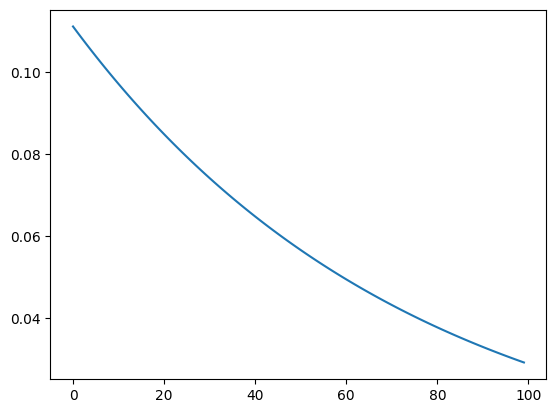

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import expon

points = np.linspace(8, 20, 100)
plt.plot(expon.pdf(points, loc=8.0, scale=9))

In [2]:
dp = DataProcessor('~/ancestry-inference/data/real_data/NC/raw/NC_graph_rel.csv')

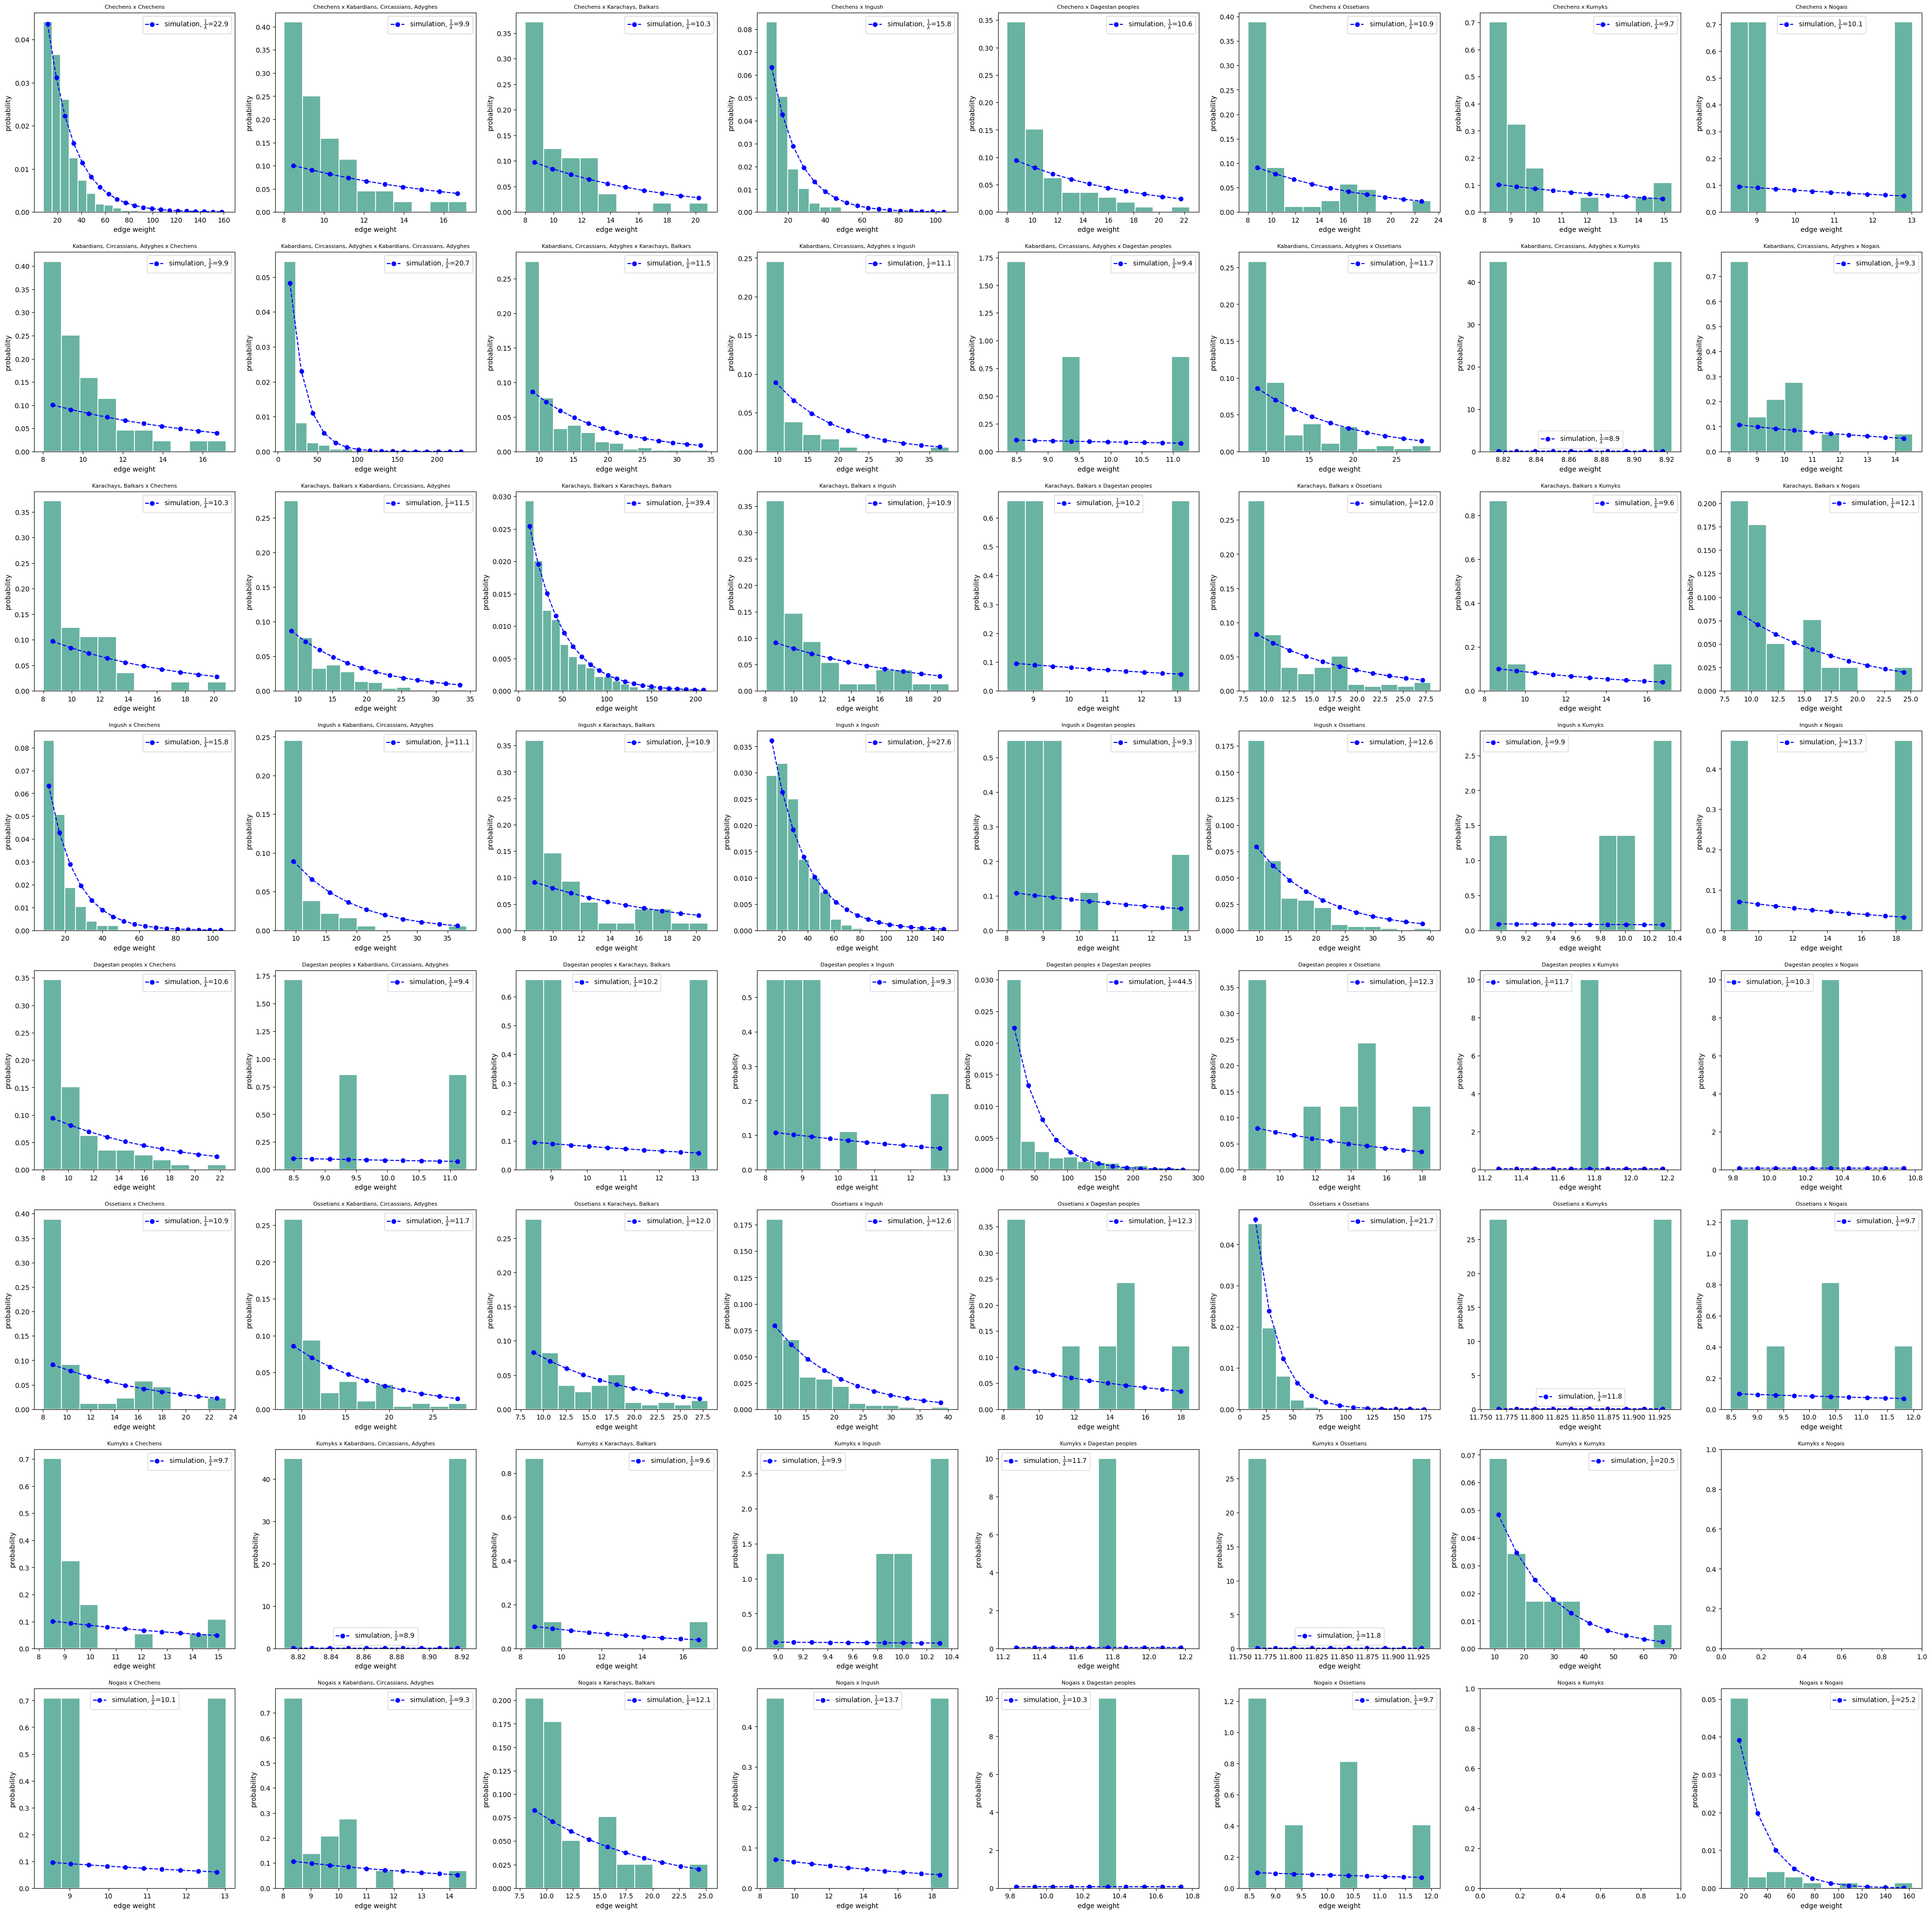

In [3]:
dp.plot_edge_weight_distribution(fig_size=(50, 50), save_path='/home/ashmelev/ancestry-inference/data/real_data/NC/imgs/weight_dist.pdf', fontsize=8, custom_class_names=['Chechens', 'Kabardians, Circassians, Adyghes', 'Karachays, Balkars', 'Ingush', 'Dagestan peoples', 'Ossetians', 'Kumyks', 'Nogais'])


In [4]:
dp = DataProcessor('~/ancestry-inference/data/real_data/WE/Western-Europe.csv')

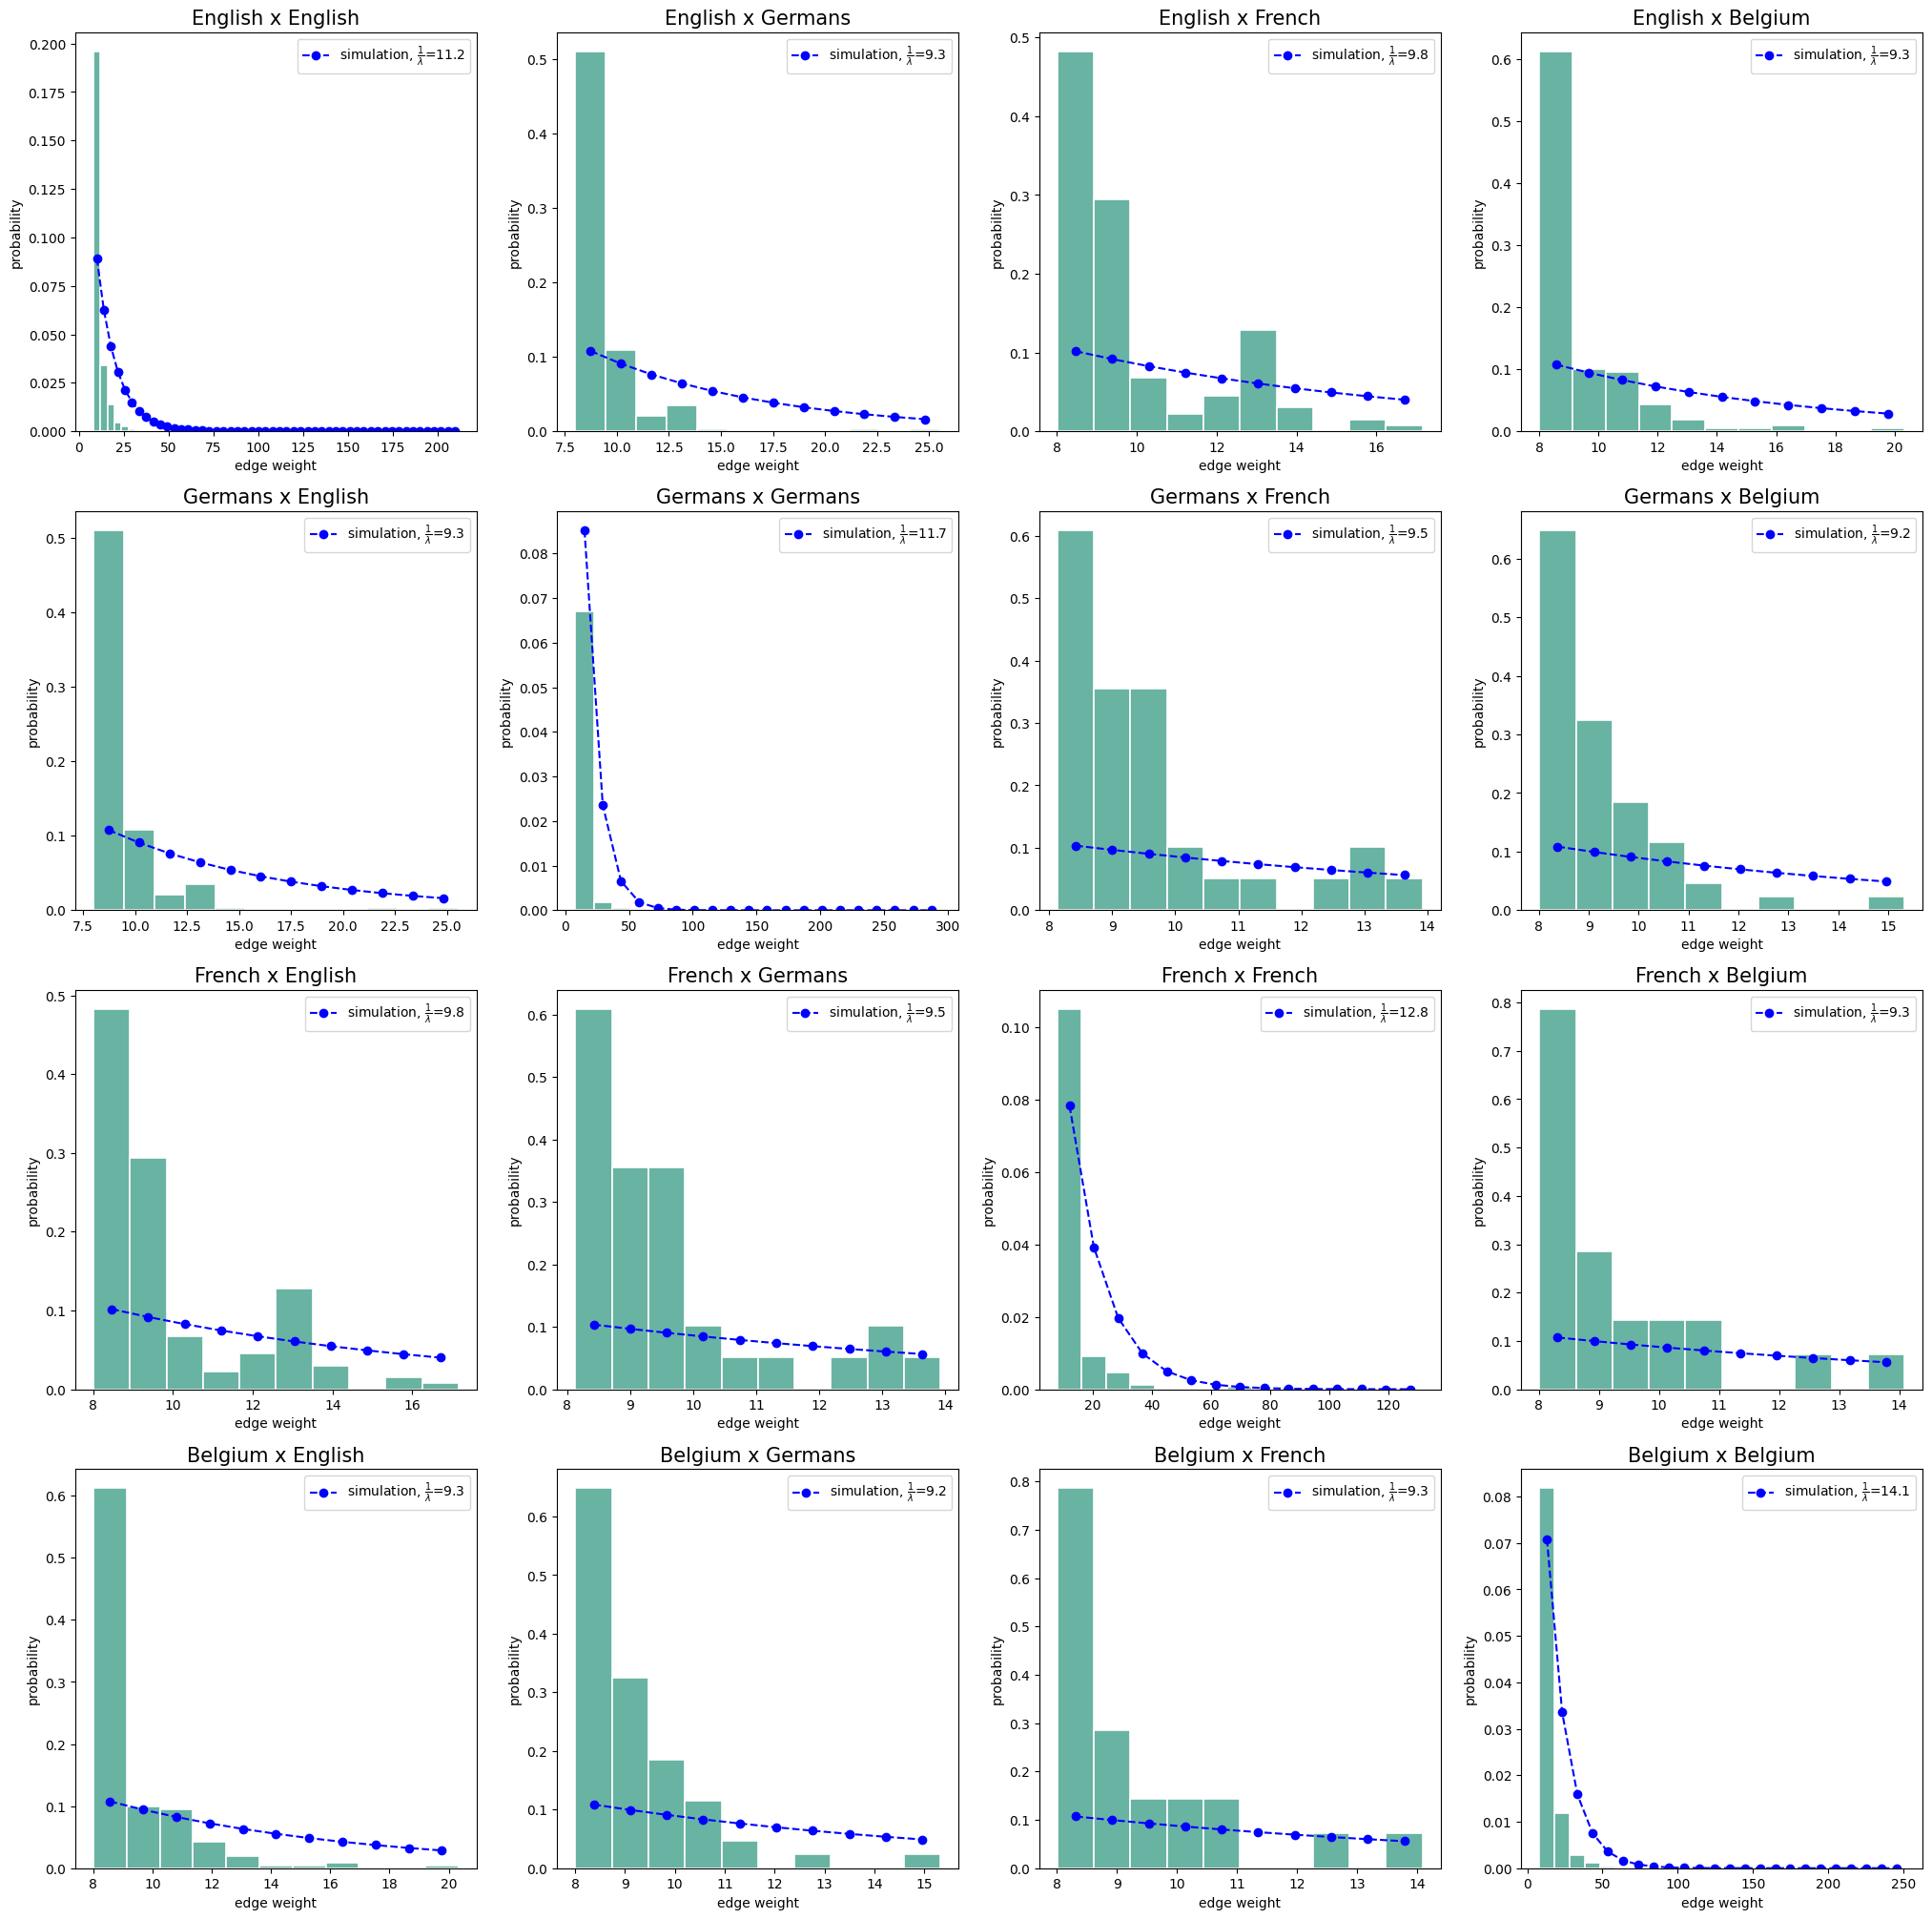

In [5]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), save_path='/home/ashmelev/ancestry-inference/data/real_data/WE/imgs/weight_dist.pdf', fontsize=15)

In [6]:
dp = DataProcessor('~/ancestry-inference/data/real_data/VU/raw/Volga.csv')

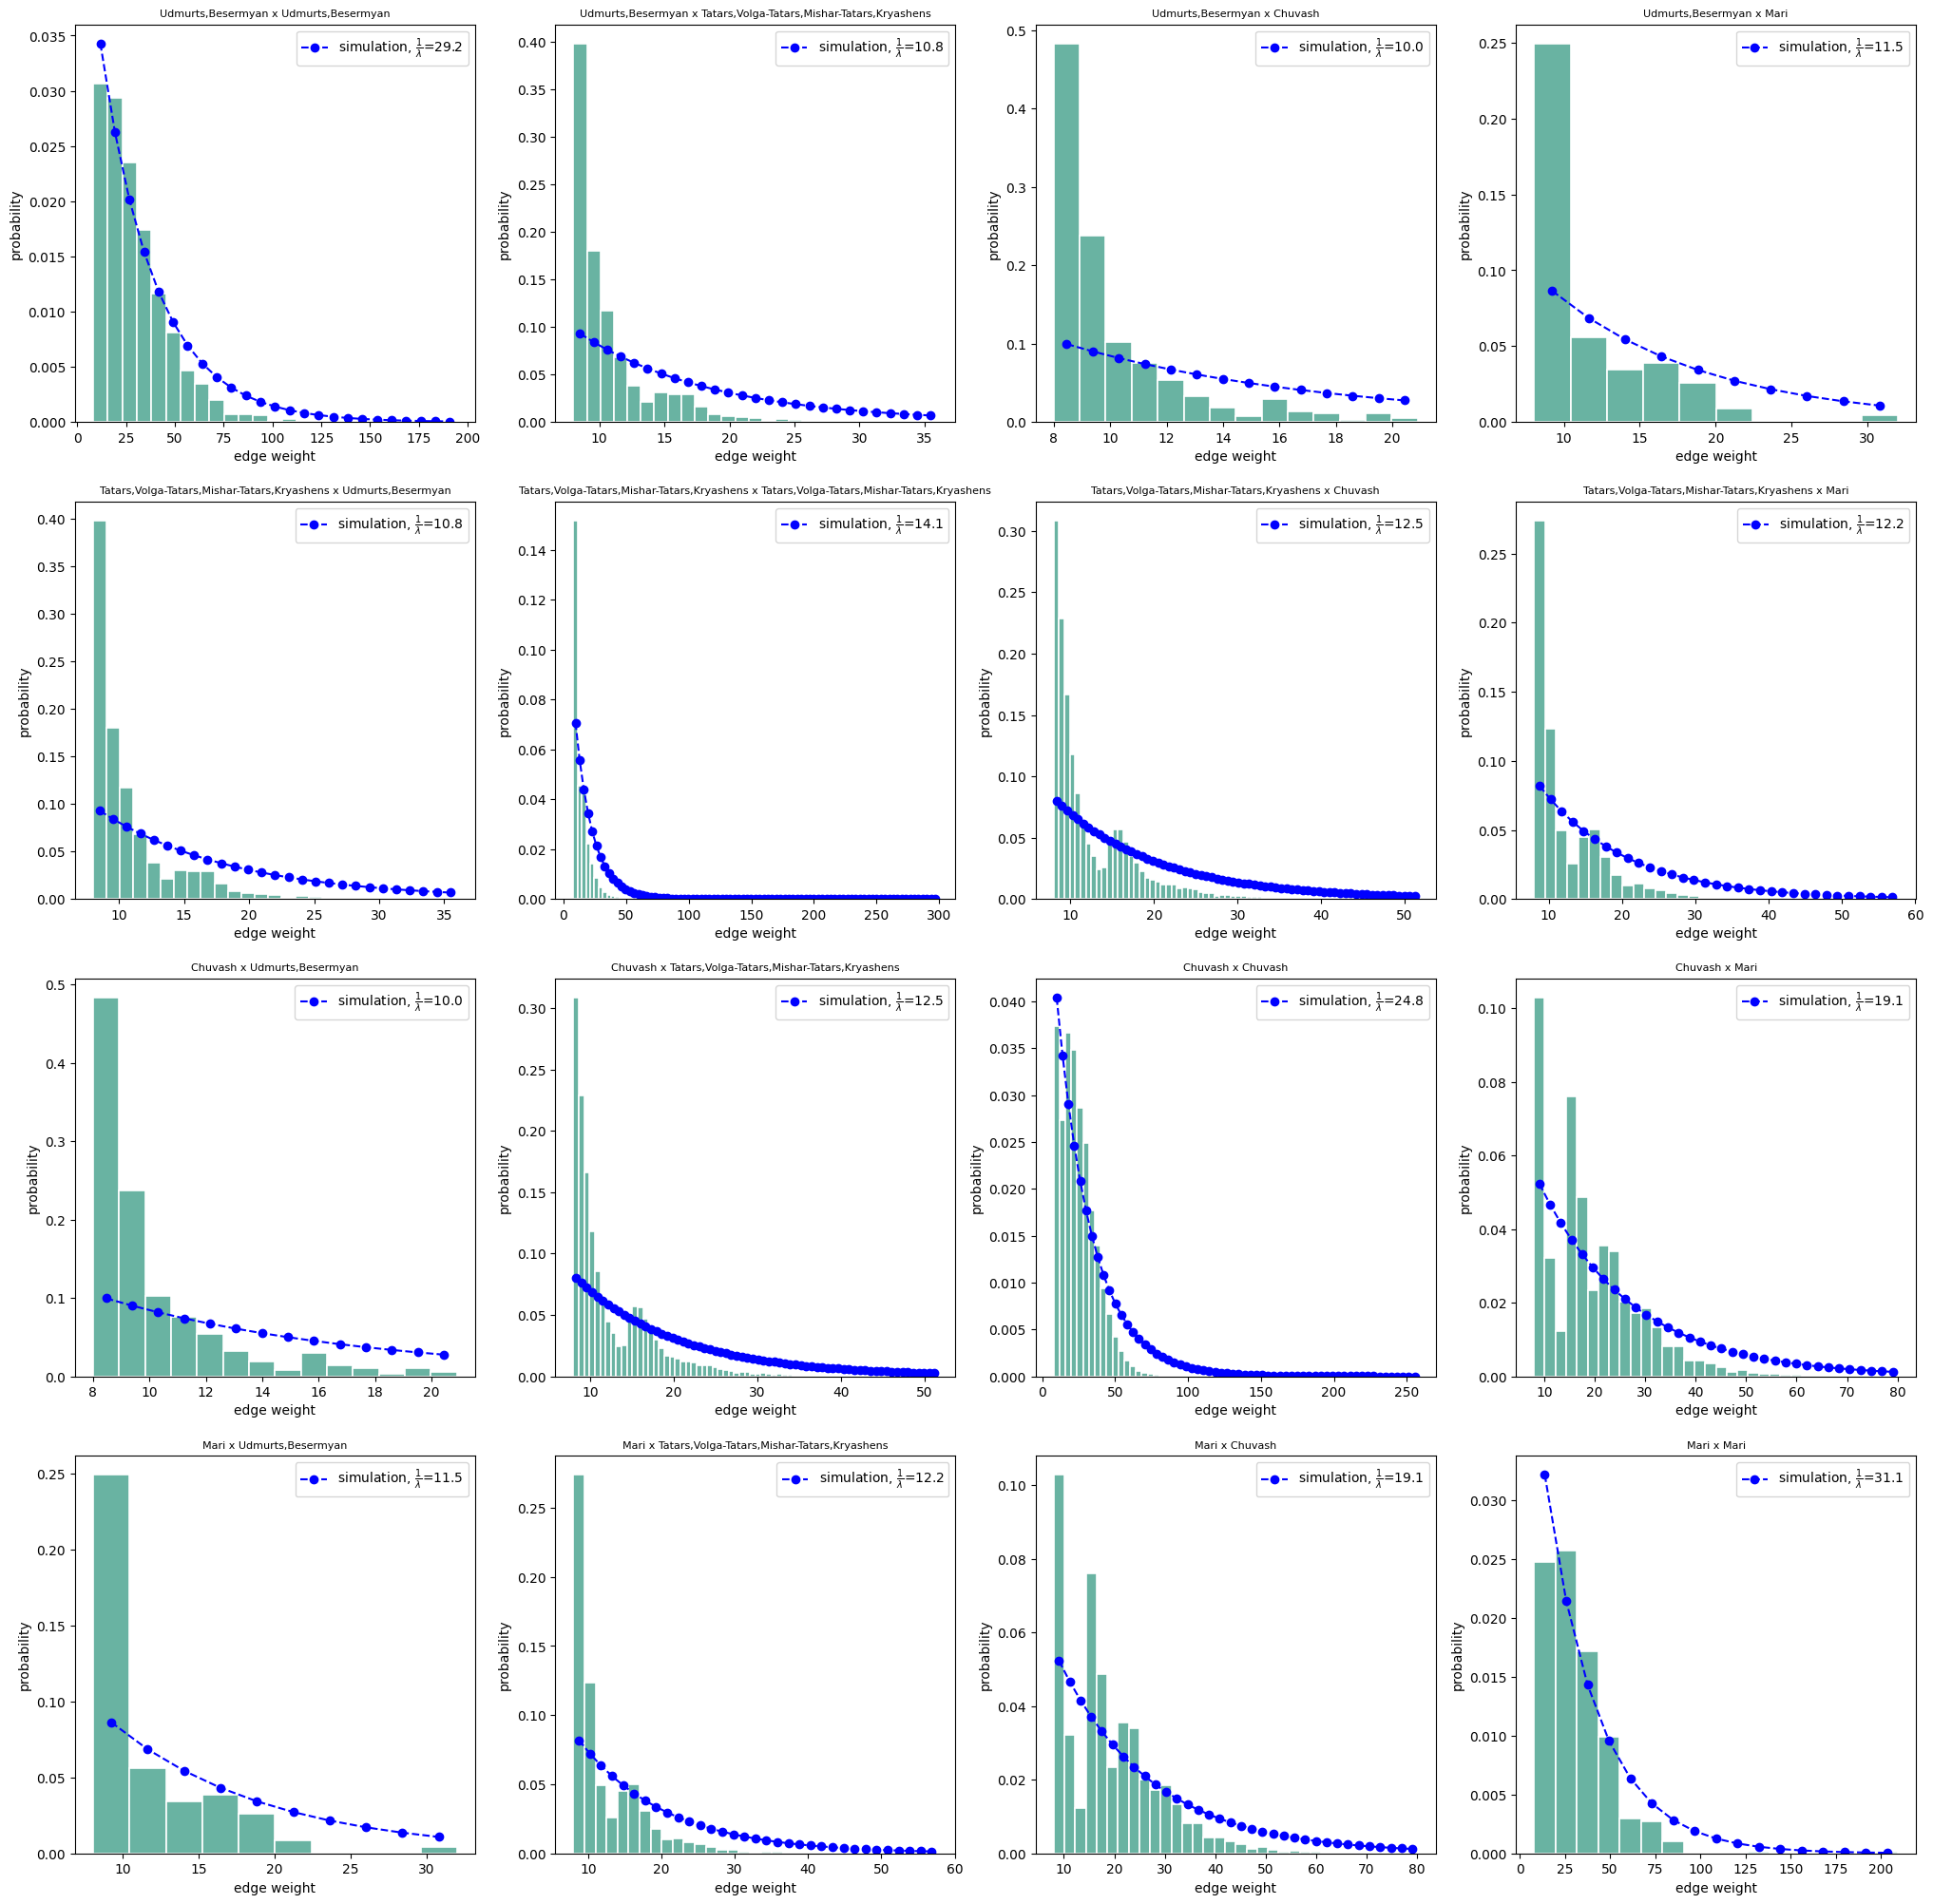

In [7]:
dp.plot_edge_weight_distribution(fig_size=(25, 25), save_path='/home/ashmelev/ancestry-inference/data/real_data/VU/imgs/weight_dist.pdf')

In [8]:
dp = DataProcessor('~/ancestry-inference/data/real_data/SC/raw/Scandinavia.csv')

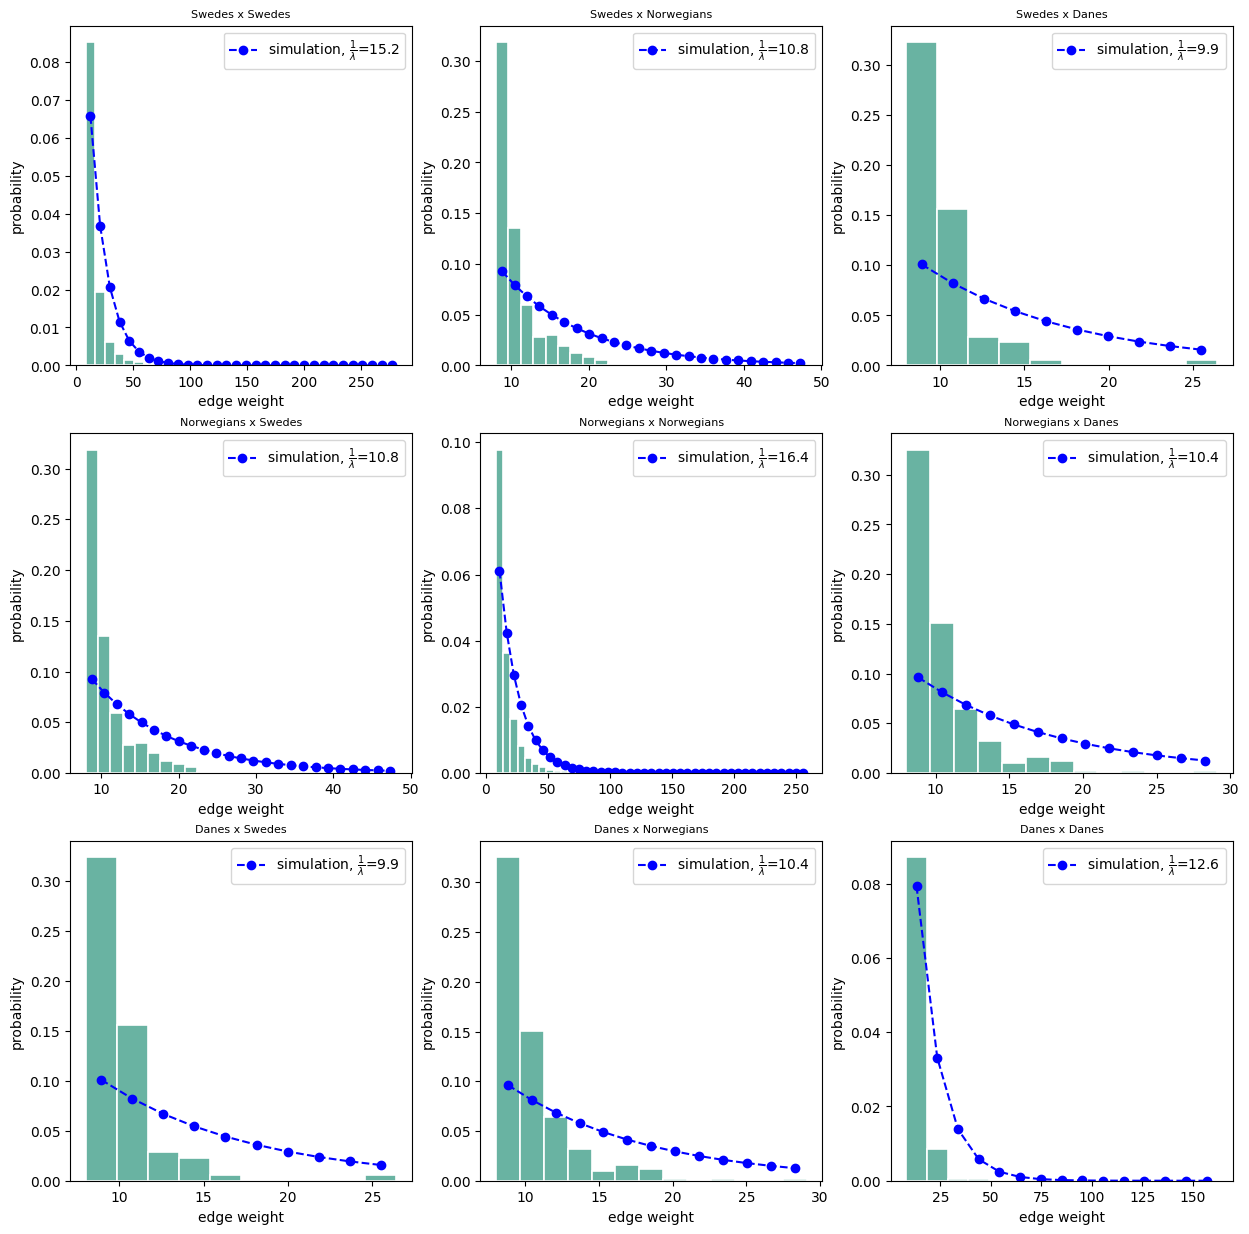

In [9]:
dp.plot_edge_weight_distribution(fig_size=(15, 15), save_path='/home/ashmelev/ancestry-inference/data/real_data/SC/imgs/weight_dist.pdf')

# Null simulations

n_pops=2
(2, 2, 100, 100)


/home/ashmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../ancinf/utils/genlink.py", line 309:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ashmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Training for data: nc_null_sim_100


Compute metrics: 100%|██████████| 40/40 [00:02<00:00, 16.96it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.83      1.00      0.91        20

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40

f1 macro score on valid dataset for class 0 which is class_0: 0.8888888888888888
f1 macro score on valid dataset for class 1 which is class_1: 0.9090909090909091
f1 macro improvement to 0.898989898989899



Training samples: 100%|██████████| 121/121 [00:01<00:00, 88.15it/s, val_best_score=0.899]

Training epochs:   5%|▌         | 1/20 [00:04<01:22,  4.34s/it]

Training report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        60
           1       0.94      0.95      0.94        61

    accuracy                           0.94       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.94      0.94      0.94       121




Compute metrics: 100%|██████████| 40/40 [00:00<00:00, 271.13it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

f1 macro score on valid dataset for class 0 which is class_0: 0.975609756097561
f1 macro score on valid dataset for class 1 which is class_1: 0.9743589743589743
f1 macro improvement to 0.9749843652282677



Training samples: 100%|██████████| 121/121 [00:01<00:00, 88.02it/s, val_best_score=0.975]

Training epochs:  10%|█         | 2/20 [00:06<00:53,  2.98s/it]

Training report
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        60
           1       0.91      0.97      0.94        61

    accuracy                           0.93       121
   macro avg       0.94      0.93      0.93       121
weighted avg       0.94      0.93      0.93       121




Compute metrics: 100%|██████████| 40/40 [00:00<00:00, 272.98it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

f1 macro score on valid dataset for class 0 which is class_0: 1.0
f1 macro score on valid dataset for class 1 which is class_1: 1.0
f1 macro improvement to 1.0



Training samples: 100%|██████████| 121/121 [00:01<00:00, 89.73it/s, val_best_score=1]

Training epochs:  15%|█▌        | 3/20 [00:08<00:43,  2.53s/it]

Training report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.95      0.95      0.95        61

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121




Compute metrics: 100%|██████████| 40/40 [00:00<00:00, 272.77it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

f1 macro score on valid dataset for class 0 which is class_0: 0.975609756097561
f1 macro score on valid dataset for class 1 which is class_1: 0.9743589743589743
Metric was not improved for the 1th time



Training samples: 100%|██████████| 121/121 [00:01<00:00, 91.34it/s, val_best_score=1]

Training epochs:  20%|██        | 4/20 [00:10<00:36,  2.31s/it]

Training report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.95      0.95      0.95        61

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121




Compute metrics: 100%|██████████| 40/40 [00:00<00:00, 270.10it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

f1 macro score on valid dataset for class 0 which is class_0: 0.975609756097561
f1 macro score on valid dataset for class 1 which is class_1: 0.9743589743589743
Metric was not improved for the 2th time



Training samples: 100%|██████████| 121/121 [00:01<00:00, 93.12it/s, val_best_score=1]

Training epochs:  25%|██▌       | 5/20 [00:12<00:36,  2.46s/it]


Training report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.95      0.95      0.95        61

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121



Compute metrics: 100%|██████████| 36/36 [00:00<00:00, 273.04it/s]


Test report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.89      0.94      0.91        17

    accuracy                           0.92        36
   macro avg       0.92      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36

f1 macro score on test dataset: 0.9166023166023166
f1 macro score on test dataset for class 0 which is class_0: 0.918918918918919
f1 macro score on test dataset for class 1 which is class_1: 0.9142857142857143


<Figure size 640x480 with 0 Axes>

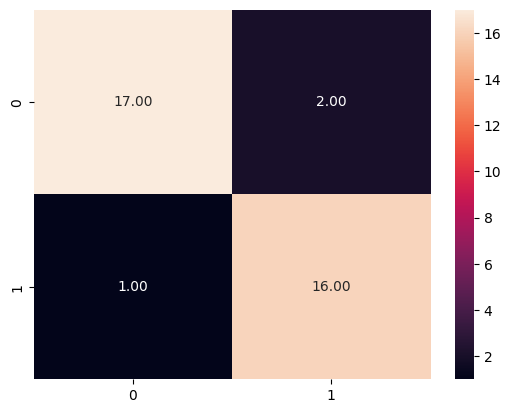

n_pops=2
(2, 2, 100, 100)


Make valid samples: 100%|██████████| 40/40 [00:00<00:00, 572.46it/s]


Isolated val node found! Restart with different seed or this node will be ignored.


Make test samples: 100%|██████████| 38/38 [00:00<00:00, 587.54it/s]


Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Training for data: nc_null_sim_100


Compute metrics: 100%|██████████| 39/39 [00:00<00:00, 271.84it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.64      0.45      0.53        20
           1       0.56      0.74      0.64        19

    accuracy                           0.59        39
   macro avg       0.60      0.59      0.58        39
weighted avg       0.60      0.59      0.58        39

f1 macro score on valid dataset for class 0 which is class_0: 0.5294117647058824
f1 macro score on valid dataset for class 1 which is class_1: 0.6363636363636364
f1 macro improvement to 0.5828877005347594



Training samples: 100%|██████████| 122/122 [00:01<00:00, 91.49it/s, val_best_score=0.583]

Training epochs:   5%|▌         | 1/20 [00:01<00:37,  1.99s/it]

Training report
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        61
           1       0.84      0.67      0.75        61

    accuracy                           0.77       122
   macro avg       0.78      0.77      0.77       122
weighted avg       0.78      0.77      0.77       122




Compute metrics: 100%|██████████| 39/39 [00:00<00:00, 272.71it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.81      0.68      0.74        19

    accuracy                           0.77        39
   macro avg       0.78      0.77      0.77        39
weighted avg       0.77      0.77      0.77        39

f1 macro score on valid dataset for class 0 which is class_0: 0.7906976744186046
f1 macro score on valid dataset for class 1 which is class_1: 0.7428571428571429
f1 macro improvement to 0.7667774086378738



Training samples: 100%|██████████| 122/122 [00:01<00:00, 91.36it/s, val_best_score=0.767]

Training epochs:   5%|▌         | 1/20 [00:03<01:12,  3.80s/it]


KeyboardInterrupt: 

In [2]:
cross_class_prob = 3.41394026e-03

cross_class_probs = [(cross_class_prob + coeff) for coeff in np.linspace(start=3.41394026e-03 / 2, stop=0.1, num=10)]

res = []

for tmp_cross_class_prob in cross_class_probs:

#     probs = np.array([[2.77715566e-01, tmp_cross_class_prob], [tmp_cross_class_prob, 5.02849789e-02]])
#     weights = np.array([[14.90908489,  1.94265021], [1.94265021, 12.70004896]])
    probs = np.array([[5.02849789e-02, tmp_cross_class_prob], [tmp_cross_class_prob, 5.02849789e-02]])
    weights = np.array([[1.94265021,  1.94265021], [1.94265021, 1.94265021]])
    
    ns = NullSimulator(2, probs, weights) # use first two classes of NC dataset as background

    means, counts, pop_index = ns.generate_matrices([100]*2)

    ns.simulate_graph(means, counts, pop_index, "/home/ashmelev/ancestry-inference/data/generated_nc/nc_null_simulations_100.csv")

    dp = DataProcessor("/home/ashmelev/ancestry-inference/data/generated_nc/nc_null_simulations_100.csv")

    dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

    dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_100')

    trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, 10, "~/runs/nc_null", 2, 20)

    res.append(trainer.run())



In [13]:
cross_class_probs

[0.00682788052,
 0.11644855382444444,
 0.22606922712888888,
 0.33568990043333335,
 0.4453105737377778,
 0.5549312470422222,
 0.6645519203466665,
 0.774172593651111,
 0.8837932669555555,
 0.99341394026]

In [22]:
res

[1.0, 0.9745744451626804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [20]:
print(max(cross_class_probs), min(cross_class_probs), len(cross_class_probs))

0.99341394026 0.00512091039 100


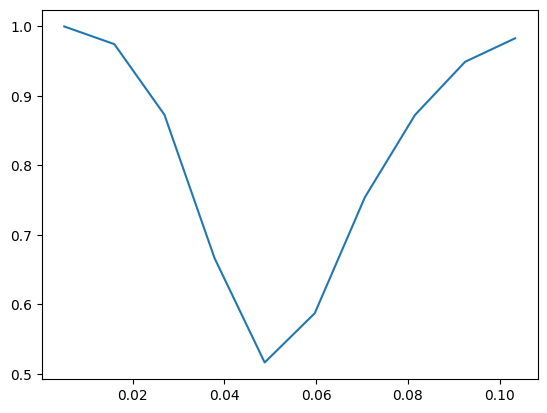

In [25]:
import matplotlib.pyplot as plt
plt.plot(cross_class_probs, res)


In [22]:
ns.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

In [23]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

In [24]:
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

In [25]:
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_100')

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "genlink.py", line 191:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

Isolated test node found! Restart with different seed or this node will be ignored.


In [26]:
trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\nc_null", 10, 20)

Compute metrics:   0%|                                                                          | 0/40 [00:00<?, ?it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|█████████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.00it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

f1 macro improvement to 1.0



Training samples: 100%|████████████████████████████████████████████| 122/122 [00:03<00:00, 32.83it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 272.94it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 115.78it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 246.78it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.28it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 265.75it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 3th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 117.21it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 216.65it/s]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122





Training samples:  10%|████▎                                       | 12/122 [00:00<00:00, 114.00it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 4th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 112.73it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 263.94it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 5th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.86it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 264.24it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 6th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.63it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 261.40it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 7th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 118.57it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 275.84it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 8th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.14it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 274.11it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 9th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.41it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 260.48it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 10th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.19it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 264.46it/s]


Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

f1 macro score on test dataset: 1.0


<Figure size 640x480 with 0 Axes>

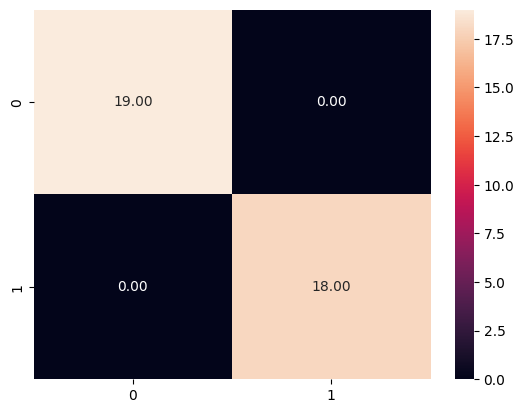

In [27]:
trainer.run()

# NC simulations

In [10]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\nc\raw\NC_graph_rel.csv")
# dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia.csv")

In [11]:
dp.classes

['чеченцы',
 'кабардинцы,черкесы,адыгейцы',
 'карачаевцы,балкарцы',
 'ингуши',
 'дагестанские народы',
 'осетины',
 'кумыки',
 'ногайцы']

In [12]:
dp.compute_simulation_params()

C:\HSE\genotek-nationality-analysis\genlink.py:328: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean() - self.offset
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\HSE\genotek-nationality-analysis\genlink.py:328: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean() - self.offset
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
dp.edge_probs

array([[2.77715566e-01, 3.41394026e-03, 5.38555692e-03, 1.31174089e-01,
        6.12725844e-03, 1.15384615e-02, 1.52046784e-02, 1.08892922e-03],
       [3.41394026e-03, 5.02849789e-02, 2.24701446e-02, 7.92619543e-03,
        2.01694232e-04, 1.66320166e-02, 7.50750751e-04, 5.12581547e-03],
       [5.38555692e-03, 2.24701446e-02, 3.61696306e-01, 1.31932021e-02,
        2.60326276e-04, 3.89087657e-02, 5.81395349e-03, 9.22213312e-03],
       [1.31174089e-01, 7.92619543e-03, 1.31932021e-02, 4.75113122e-01,
        2.58323766e-03, 7.10059172e-02, 5.34188034e-03, 1.32625995e-03],
       [6.12725844e-03, 2.01694232e-04, 2.60326276e-04, 2.58323766e-03,
        3.28831474e-02, 1.14810563e-03, 4.14593698e-04, 2.57334020e-04],
       [1.15384615e-02, 1.66320166e-02, 3.89087657e-02, 7.10059172e-02,
        1.14810563e-03, 2.28506787e-01, 2.13675214e-03, 4.64190981e-03],
       [1.52046784e-02, 7.50750751e-04, 5.81395349e-03, 5.34188034e-03,
        4.14593698e-04, 2.13675214e-03, 1.58333333e-01, 0.

In [14]:
dp.mean_weight

array([[14.90908489,  1.94265021,  2.30568932,  7.77972619,  2.61010051,
         2.93902175,  1.65329692,  2.14949   ],
       [ 1.94265021, 12.70004896,  3.5279301 ,  3.07051311,  1.3875125 ,
         3.66120656,  0.867145  ,  1.32968409],
       [ 2.30568932,  3.5279301 , 31.37447639,  2.85508017,  2.20767333,
         4.03104862,  1.64853889,  4.05216522],
       [ 7.77972619,  3.07051311,  2.85508017, 19.63135611,  1.25224833,
         4.60230609,  1.91038   ,  5.65972   ],
       [ 2.61010051,  1.3875125 ,  2.20767333,  1.25224833, 36.52264036,
         4.34636875,  3.7234    ,  2.2861    ],
       [ 2.93902175,  3.66120656,  4.03104862,  4.60230609,  4.34636875,
        13.66507809,  3.84755   ,  1.68632286],
       [ 1.65329692,  0.867145  ,  1.64853889,  1.91038   ,  3.7234    ,
         3.84755   , 12.48511053, -8.        ],
       [ 2.14949   ,  1.32968409,  4.05216522,  5.65972   ,  2.2861    ,
         1.68632286, -8.        , 17.22307933]])

In [11]:
means, counts, pop_index = dp.generate_matrices([500]*3)

n_pops=3
(3, 3, 500, 500)
pop_i=0 pop_j=0
total_segments=15128
pop_i=1 pop_j=0
total_segments=2774
pop_i=1 pop_j=1
total_segments=19160
pop_i=2 pop_j=0
total_segments=340
pop_i=2 pop_j=1
total_segments=788
pop_i=2 pop_j=2
total_segments=7304


In [12]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [13]:
import numpy as np
check_symmetric(counts)

True

In [7]:
print(counts.shape)

(800, 800)


In [16]:
dp.classes

['Swedes', 'Norwegians', 'Danes']

In [14]:
dp.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\data\generated_sc\raw\simulated_sc_500.csv")

In [17]:
for i in range(3500, 4000):
    print(G.nodes[i]['y'])

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [11]:
dp.edge_probs.round(2)

array([[0.28, 0.  , 0.01, 0.13, 0.01, 0.01, 0.02, 0.  ],
       [0.  , 0.05, 0.02, 0.01, 0.  , 0.02, 0.  , 0.01],
       [0.01, 0.02, 0.36, 0.01, 0.  , 0.04, 0.01, 0.01],
       [0.13, 0.01, 0.01, 0.48, 0.  , 0.07, 0.01, 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.01, 0.02, 0.04, 0.07, 0.  , 0.23, 0.  , 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.16, 0.  ],
       [0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.11]])

In [7]:
dp.classes

['чеченцы',
 'кабардинцы,черкесы,адыгейцы',
 'карачаевцы,балкарцы',
 'ингуши',
 'дагестанские народы',
 'осетины',
 'кумыки',
 'ногайцы']

In [11]:
pop_index

array([0, 0, 0, ..., 7, 7, 7])

In [6]:
df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\data\generated_we\raw\simulated_we.csv", sep=',')
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum
0,node_19,node_7,English,English,10.098513
1,node_28,node_14,English,English,17.500695
2,node_29,node_0,English,English,10.148421
3,node_30,node_1,English,English,12.850058
4,node_30,node_22,English,English,8.544812
...,...,...,...,...,...
6091,node_1999,node_1865,Belgium,Belgium,12.662206
6092,node_1999,node_1886,Belgium,Belgium,31.445615
6093,node_1999,node_1887,Belgium,Belgium,9.249153
6094,node_1999,node_1905,Belgium,Belgium,10.947118


In [7]:
df[df.node_id2=='node_0'].label_id2.unique()

array(['English'], dtype=object)

In [11]:
df[((df.label_id1 == 'чеченцы') & (df.label_id2 == 'кабардинцы,черкесы,адыгейцы')) | ((df.label_id1 == 'кабардинцы,черкесы,адыгейцы') & (df.label_id2 == 'чеченцы'))].ibd_sum.mean()

10.094627886661257

In [9]:
df[(df.label_id1 == 'English') & (df.label_id2 == 'English')].ibd_sum.mean()

11.176547184133804

In [50]:
(np.random.default_rng().exponential(scale=4, size=1000)+20).mean()

23.869373102413423

# WE

In [2]:
# df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Western-Europe_weights_partial_labels.csv")
# df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Volga_weights_partial_labels.csv")
df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia_weights_partial_labels.csv")
df

,node_id1,node_id2,ibd_sum,ibd_n,ibd_max,label_id1,label_id2
0,node_2,node_1829,9.50609,1,9.50609,Estonians,Swedes
1,node_2,node_1837,9.29771,1,9.29771,Estonians,Swedes
2,node_2,node_8869,10.65770,1,10.65770,Estonians,Swedes
3,node_2,node_8891,8.23524,1,8.23524,Estonians,Swedes
4,node_2,node_11641,13.71090,1,13.71090,Estonians,Swedes
...,...,...,...,...,...,...,...
33201,node_11652,node_15314,9.14623,1,9.14623,Swedes,Russians
33202,node_11653,node_13240,8.59061,1,8.59061,Swedes,Russians
33203,node_11653,node_12704,8.69799,1,8.69799,Swedes,"Karelians,Veps"
33204,node_11653,node_12737,11.75780,1,11.75780,Swedes,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens"


In [3]:
df.label_id1.unique()

array(['Estonians', 'Poles', 'Dolgans,Yakuts', 'Kazakhs',
       'Udmurts,Besermyan', 'Uzbeks',
       'Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Ket', 'Mordvins',
       'Bashkirs', 'Kabardians,Cherkess,Adygeans', 'Kyrgyz',
       'Karelians,Veps', 'Belarusians', 'Ukrainians', 'Chuvash', 'Komi',
       'Moldovans', 'Evenks', 'Ashkenazim', 'English', 'Swedes', 'Roma',
       'Basques', 'Balkan', 'Germans', 'Armenians,Hemshins', 'French',
       'Finns', 'Sephardim', 'Scots', 'Puerto-Ricans', 'Spaniards',
       'Tamils', 'Pashtuns', 'Khanty,Mansi', 'Albanians,Greeks',
       'Mexicans', 'Norwegians', 'Ossetians', 'Lithuanians', 'Sami',
       'Czechs,Slovaks', 'Danes', 'Tuscans', 'Belgium'], dtype=object)

In [24]:
df.ibd_sum.min()

8.00001

In [5]:
# df = df[['node_id1','node_id2','label_id1','label_id2','ibd_sum','ibd_n','ibd_max']]
# df

In [4]:
selected_rows = []
# sel_pop = ['English', 'Germans', 'French', 'Belgium']
# sel_pop = ['Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Chuvash', 'Udmurts,Besermyan', 'Mari']
sel_pop = ['Norwegians', 'Swedes', 'Danes']

for i in range(df.shape[0]):
    row = df.iloc[i, 5:]
    if row[0] in sel_pop and row[1] in sel_pop:
        selected_rows.append(True)
    else:
        selected_rows.append(False)

In [6]:
df_mod = df[selected_rows][['node_id1', 'node_id2', 'label_id1', 'label_id2',  'ibd_sum', 'ibd_n', 'ibd_max']]
df_mod

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
498,node_1799,node_1821,Swedes,Swedes,18.25960,1,18.25960
499,node_1799,node_1841,Swedes,Swedes,8.35242,1,8.35242
500,node_1799,node_1867,Swedes,Swedes,9.57823,1,9.57823
523,node_1799,node_8828,Swedes,Swedes,11.78040,1,11.78040
524,node_1799,node_8832,Swedes,Swedes,11.22940,1,11.22940
...,...,...,...,...,...,...,...
33170,node_11643,node_11647,Swedes,Swedes,10.38140,1,10.38140
33171,node_11643,node_11648,Swedes,Swedes,10.26240,1,10.26240
33175,node_11645,node_11651,Swedes,Swedes,10.72090,1,10.72090
33180,node_11646,node_11651,Swedes,Swedes,15.19660,2,8.40791


In [7]:
df_mod.to_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia.csv", index=False)

# runs

In [84]:
def set_global_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [85]:
set_global_seed(42)

In [12]:
# torch.load(r"C:\HSE\genotek-nationality-analysis\data\mapping_indices.pt")

In [2]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Western-Europe.csv")

In [3]:
dp.df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,0,76,0,0,10.65130,1,10.65130
1,0,85,0,0,8.51599,1,8.51599
2,0,119,0,0,11.50810,1,11.50810
3,0,371,0,0,14.50930,1,14.50930
4,0,704,0,0,9.06940,1,9.06940
...,...,...,...,...,...,...,...
22041,3395,3472,5,5,8.15428,1,8.15428
22042,3396,3846,5,5,8.40182,1,8.40182
22043,3397,3888,5,5,8.17397,1,8.17397
22044,3398,3886,5,5,9.03886,1,9.03886


In [4]:
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

In [88]:
nc.load_train_valid_test_nodes(r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\train_indices.pt",
                              r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\val_indices.pt",
                              r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\test_indices.pt",
                              'torch')

In [6]:
import numpy as np
tmp_df = nc.node_classes_sorted.loc[nc.node_classes_sorted['node'].isin(nc.valid_nodes)]
np.unique(tmp_df['class_id'].to_numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([19, 29, 17, 10, 26, 10,  3,  5], dtype=int64))

In [21]:
nc.train_nodes

[0,
 2,
 3,
 5,
 6,
 7,
 9,
 13,
 17,
 18,
 19,
 20,
 22,
 29,
 30,
 31,
 33,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 78,
 79,
 81,
 84,
 86,
 87,
 88,
 92,
 93,
 96,
 100,
 102,
 104,
 105,
 106,
 110,
 111,
 112,
 113,
 114,
 115,
 119,
 122,
 124,
 125,
 127,
 128,
 130,
 132,
 133,
 138,
 139,
 140,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 163,
 166,
 167,
 168,
 170,
 171,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 186,
 188,
 190,
 193,
 194,
 195,
 197,
 198,
 199,
 200,
 203,
 204,
 205,
 209,
 211,
 213,
 216,
 217,
 218,
 219,
 220,
 223,
 224,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 236,
 237,
 238,
 243,
 244,
 245,
 247,
 249,
 250,
 252,
 253,
 254,
 258,
 259,
 261,
 262,
 263,
 265,
 266,
 268,
 269,
 270,
 274,
 275,
 277,
 278,
 279,
 280,
 282,
 283,
 285,
 287,
 290,
 291,
 294,
 296,
 297,
 298,
 299,
 3

In [5]:
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'we_my_random')

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "genlink.py", line 181:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:   8%|████▊                                                        | 62/791 [00:00<00:08, 83.98it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  14%|████████▏                                                   | 108/791 [00:01<00:07, 86.39it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  16%|█████████▌                                                  | 126/791 [00:01<00:07, 86.36it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  19%|███████████▌                                                | 153/791 [00:01<00:07, 83.81it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  22%|████████████▉                                               | 171/791 [00:02<00:07, 82.57it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  29%|█████████████████▋                                          | 233/791 [00:02<00:06, 86.64it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  34%|████████████████████▍                                       | 270/791 [00:03<00:06, 83.17it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  36%|█████████████████████▊                                      | 288/791 [00:03<00:06, 83.12it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  40%|███████████████████████▉                                    | 315/791 [00:03<00:05, 84.48it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  43%|█████████████████████████▉                                  | 342/791 [00:04<00:05, 81.44it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  47%|███████████████████████████▉                                | 369/791 [00:04<00:05, 81.05it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  52%|███████████████████████████████▎                            | 413/791 [00:05<00:04, 80.46it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  55%|█████████████████████████████████▎                          | 439/791 [00:05<00:04, 81.34it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  61%|████████████████████████████████████▌                       | 482/791 [00:05<00:03, 80.99it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  67%|████████████████████████████████████████                    | 528/791 [00:06<00:03, 86.50it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  70%|██████████████████████████████████████████                  | 555/791 [00:06<00:02, 82.77it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  75%|████████████████████████████████████████████▊               | 591/791 [00:07<00:02, 80.45it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  85%|███████████████████████████████████████████████████▏        | 674/791 [00:08<00:01, 81.03it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  92%|███████████████████████████████████████████████████████     | 726/791 [00:08<00:00, 79.95it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  97%|██████████████████████████████████████████████████████████▎ | 769/791 [00:09<00:00, 80.32it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples: 100%|████████████████████████████████████████████████████████████| 791/791 [00:09<00:00, 81.38it/s]


Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make test samples:   2%|█▍                                                            | 18/788 [00:00<00:09, 81.47it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:   8%|████▊                                                         | 61/788 [00:00<00:08, 80.90it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  13%|████████▏                                                    | 105/788 [00:01<00:08, 83.30it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  18%|██████████▉                                                  | 142/788 [00:01<00:07, 86.74it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  24%|██████████████▋                                              | 189/788 [00:02<00:06, 88.59it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.



Make test samples:  25%|███████████████▍                                             | 199/788 [00:02<00:06, 90.02it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  32%|███████████████████▋                                         | 254/788 [00:03<00:06, 85.39it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  35%|█████████████████████                                        | 272/788 [00:03<00:06, 83.32it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  40%|████████████████████████▌                                    | 317/788 [00:03<00:05, 80.67it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  43%|██████████████████████████                                   | 336/788 [00:04<00:05, 84.13it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  45%|███████████████████████████▍                                 | 354/788 [00:04<00:05, 82.14it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  48%|█████████████████████████████▍                               | 381/788 [00:04<00:04, 81.90it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  52%|███████████████████████████████▋                             | 409/788 [00:04<00:04, 83.03it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  55%|█████████████████████████████████▊                           | 436/788 [00:05<00:04, 83.96it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  60%|████████████████████████████████████▌                        | 472/788 [00:05<00:03, 83.82it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  63%|██████████████████████████████████████▋                      | 499/788 [00:06<00:03, 81.46it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  66%|████████████████████████████████████████▏                    | 519/788 [00:06<00:03, 84.72it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  68%|█████████████████████████████████████████▌                   | 537/788 [00:06<00:03, 83.29it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  74%|█████████████████████████████████████████████                | 582/788 [00:07<00:02, 81.43it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  78%|███████████████████████████████████████████████▍             | 612/788 [00:07<00:01, 90.03it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  81%|█████████████████████████████████████████████████▌           | 640/788 [00:07<00:01, 83.57it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  86%|████████████████████████████████████████████████████▎        | 676/788 [00:08<00:01, 82.93it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  89%|██████████████████████████████████████████████████████▍      | 703/788 [00:08<00:01, 83.06it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  95%|█████████████████████████████████████████████████████████▉   | 748/788 [00:09<00:00, 80.56it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  97%|███████████████████████████████████████████████████████████▎ | 766/788 [00:09<00:00, 83.36it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples: 100%|█████████████████████████████████████████████████████████████| 788/788 [00:09<00:00, 82.79it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


In [7]:
torch.sum(nc.array_of_graphs_for_testing[10].x != 1.)

tensor(2705)

In [6]:
nc.array_of_graphs_for_testing[10].x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.1250, 0.1250, 0.1250,  ..., 0.1250, 0.1250, 0.1250]],
       dtype=torch.float64)

In [7]:
nc.classes

['карачаевцы,балкарцы',
 'осетины',
 'кабардинцы,черкесы,адыгейцы',
 'ингуши',
 'кумыки',
 'ногайцы',
 'чеченцы',
 'дагестанские народы']

In [11]:
trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1., 2., 100., 100., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\we\my_random", 10, 20)

Compute metrics:   0%|▏                                                                | 2/754 [00:00<00:38, 19.66it/s]

Training for data: we_my_random



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:03<00:00, 242.54it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.64      0.51      0.57       136
           2       0.20      0.15      0.18        78
           3       0.00      0.00      0.00         5
           4       0.00      0.17      0.00         6
           5       0.65      1.00      0.79        68

    accuracy                           0.20       754
   macro avg       0.25      0.31      0.26       754
weighted avg       0.19      0.20      0.19       754

f1 macro improvement to 0.2565239752308907



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.43it/s, val_best_score=0.257]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 264.60it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.75it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

f1 macro improvement to 0.6144679690620096



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.53it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.62it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 267.02it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 1th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.63it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.00it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 268.63it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 2th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.53it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 260.79it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 259.49it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 3th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.43it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 265.06it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.21it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 4th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.88it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.36it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.63it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 5th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.19it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.67it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 261.14it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 6th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.92it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.34it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 257.83it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 7th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.46it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.05it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.99it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 8th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.14it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.30it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.38it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 9th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.37it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 264.56it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.72it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 10th time



Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.09it/s, val_best_score=0.614]

Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.34it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 735/735 [00:02<00:00, 264.67it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Test report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       458
           1       0.94      0.94      0.94       127
           2       0.88      0.74      0.80        72
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         6
           5       0.96      0.96      0.96        68

    accuracy                           0.95       735
   macro avg       0.62      0.61      0.61       735
weighted avg       0.93      0.95      0.94       735

f1 macro score on test dataset: 0.6125904502999738


<Figure size 640x480 with 0 Axes>

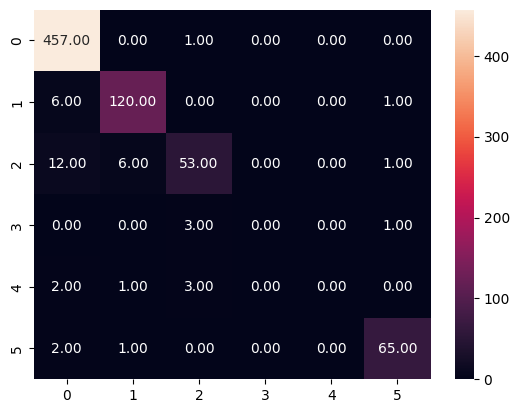

In [12]:
trainer.run()

In [13]:
dp.classes

['English', 'Germans', 'French', 'Spaniards', 'Tuscans', 'Belgium']

In [7]:
len(nc.valid_nodes)

123

In [8]:
len(nc.array_of_graphs_for_validation)

119

In [39]:
cr.node_classes_sorted

,node,class_id
0,0,0
23,1,0
45,2,0
61,3,0
74,4,0
...,...,...
14467,3762,1
14492,3763,2
16500,3764,1
21116,3765,2


In [48]:
from sklearn.metrics import f1_score

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
f1_score(y_true, y_pred, average='weighted', labels=[0])

0.8

In [1]:
type([])

list

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6



# tmp

In [20]:
import networkx as nx

In [21]:
G = nx.Graph()
G.add_edge(0, 1, pop_index_1='a', pop_index_2='b', weigth=1)
G.add_edge(0, 2, pop_index_1='a', pop_index_2='c', weigth=2)
G.add_edge(0, 3, pop_index_1='a', pop_index_2='d', weigth=3)
nx.write_edgelist(G, 'tmp.csv', data=['pop_index_1', 'pop_index_2', 'weigth'])

In [23]:
G.nodes

NodeView((0, 1, 2, 3))

In [22]:
pd.read_csv('tmp.csv', header=None, sep=' ')

,0,1,2,3,4
0,0,1,a,b,1
1,0,2,a,c,2
2,0,3,a,d,3
